In [50]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing

###Read data

In [51]:
# Load data
df = pd.read_csv('/BA_trainmodel/data/NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


###Reset index

In [52]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [53]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,46.259998
1,45.049999
2,47.130001
3,47.740002
4,49.209999
5,49.410000
6,50.049999
7,49.869999
8,49.680000
9,49.669998


###Data normalization

In [54]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.23668902],
       [0.22315435],
       [0.24642059],
       ...,
       [0.37852348],
       [0.37684565],
       [0.38601791]])

###Data splitting

In [55]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

In [56]:
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0
    
    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))
        
    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)


##Model training and testing

###Define the parameter GBT

In [57]:
# Grid of time_steps to try
time_step_grid = [30, 50, 60, 70, 100]

In [58]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

In [59]:
# Defining the GBT Model
gbt = GradientBoostingRegressor(n_iter_no_change=5, tol=0.03, random_state=0)

In [60]:
random_search = RandomizedSearchCV(estimator=gbt, param_distributions=param_grid, n_iter=250, cv=10, verbose=2, random_state=0, n_jobs=-1)

In [61]:
best_val_MAPE = float("inf")
best_params = None
best_time_step = None
best_gbt = None
best_y_pred_val_inv = None
best_y_val_inv = None

In [62]:
for time_step in time_step_grid:
    # Reshape into X=t,t+1,t+2..t+time_step_grid[i] and Y=t+time_step_grid[i]
    X_train, y_train = create_dataset(train_data, time_step)

    # Prepare previous data for validation set
    last_train_data = train_data[-time_step:]

    # Create validation set
    X_val, y_val = create_dataset(val_data, time_step, last_train_data)

    # Fitting the random search model
    random_search.fit(X_train, y_train)

    # Create a new model with these parameters
    candidate_gbt = GradientBoostingRegressor(**random_search.best_params_, random_state=0)

    # Fit the model with the training data
    candidate_gbt.fit(X_train, y_train)

    # Predicting on validation data
    y_pred_val = candidate_gbt.predict(X_val)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    valid_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)

    # Check if this model is better than the previous ones
    if valid_MAPE < best_val_MAPE:
        best_params = random_search.best_params_
        best_val_MAPE = valid_MAPE
        best_time_step = time_step
        best_gbt = candidate_gbt
        best_y_pred_val_inv = y_pred_val_inv
        best_y_val_inv = y_val_inv

    # Print the MAPE for this time_step
    print(f"Time step: {time_step}, Validation MAPE: {valid_MAPE}")

print("Best time step: ", best_time_step)
print("Best parameters: ", best_params)
print("Validation MAPE with best time step and parameters: ", best_val_MAPE)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


Time step: 30, Validation MAPE: 0.21060927820992506
Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Time step: 50, Validation MAPE: 0.2091326071250468
Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Time step: 60, Validation MAPE: 0.20388765440299692
Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Time step: 70, Validation MAPE: 0.20342111307195676
Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Time step: 100, Validation MAPE: 0.20345883163355596
Best time step:  70
Best parameters:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.15}
Validation MAPE with best time step and parameters:  0.20342111307195676


##Train with best time step and best parameters

In [63]:
# Once we have the best params and time step, we recreate all datasets and fit the model again
X_train, y_train = create_dataset(train_data, best_time_step)

# Prepare previous data for val set
last_ppoints_train = train_data[-best_time_step:]
X_val, y_val = create_dataset(val_data, best_time_step,last_ppoints_train)


# Prepare previous data for test set
last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)

In [64]:
# Create a new model with the best parameters
best_gbt = GradientBoostingRegressor(**best_params, random_state=0)

In [65]:
# Fit the model with the combined training data
best_gbt.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.15, min_samples_split=4,
                          n_estimators=300, random_state=0)

In [66]:
# Now use this to make predictions
y_pred_val =best_gbt.predict(X_val)
y_pred_test=best_gbt.predict(X_test)

##Testing process

In [67]:
# And scale the predictions back to the original range
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1))


In [68]:
val_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_RMSE = mean_squared_error(y_val_inv, y_pred_val_inv, squared=False)
val_MSLE = mean_squared_log_error(y_val_inv, y_pred_val_inv)
print('MAPE on the data val:', val_MAPE)
print('RMSE on the data val', val_RMSE)
print('MSLE on the data val', val_MSLE)

MAPE on the data val: 0.20342111307195676
RMSE on the data val 23.554078758531002
MSLE on the data val 0.08736141724029459


In [69]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.19253326325501716
RMSE on the data test 17.854381175977405
MSLE on the data test 0.0583331462827063


##Predicting the next 30 days

In [70]:
# Predict the closing prices for the next 30 days
x_input=test_data[-best_time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=best_time_step
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        next_date = best_gbt.predict(x_input)
        print("{} day output {}".format(i,next_date))
        temp_input.extend(next_date.tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(next_date.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps))
        next_date = best_gbt.predict(x_input)
        print(next_date[0])
        temp_input.extend(next_date.tolist())
        print(len(temp_input))
        lst_output.extend(next_date.tolist())
        i=i+1


0.3938627997156304
71
1 day input [0.62718119 0.60950779 0.62885906 0.6005593  0.56677849 0.54776286
 0.57058167 0.5355705  0.53221477 0.53255032 0.54507832 0.56062641
 0.5511186  0.53836692 0.52203576 0.53031322 0.52628638 0.53255032
 0.53221477 0.54530199 0.54854585 0.53624162 0.51823266 0.47997765
 0.51554812 0.53914992 0.52695748 0.53523487 0.53501119 0.55682323
 0.5459732  0.53747206 0.52572705 0.50917229 0.51599556 0.49642062
 0.49183445 0.49105145 0.49552575 0.50055926 0.48847871 0.46923941
 0.42684562 0.44675616 0.44071588 0.43333333 0.42796422 0.40984342
 0.38914988 0.41521254 0.41342283 0.40268454 0.4067114  0.4121924
 0.40111856 0.39328857 0.36442953 0.34977628 0.34440715 0.32807606
 0.30872484 0.31689038 0.33210292 0.33836687 0.35928413 0.38299776
 0.37852348 0.37684565 0.38601791 0.3938628 ]
1 day output [0.39178533]
2 day input [0.60950779 0.62885906 0.6005593  0.56677849 0.54776286 0.57058167
 0.5355705  0.53221477 0.53255032 0.54507832 0.56062641 0.5511186
 0.53836692 0

In [71]:
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print('Predicted closing prices for the next 30 days:')
print(lst_output)

Predicted closing prices for the next 30 days:
[[60.31133429]
 [60.12560852]
 [60.73720005]
 [61.10492312]
 [60.77643087]
 [60.83561009]
 [60.97911381]
 [60.72428289]
 [60.75751206]
 [60.64017882]
 [61.0593557 ]
 [60.2189424 ]
 [60.6988244 ]
 [62.66883688]
 [63.11301036]
 [63.63101172]
 [62.99413459]
 [63.68668467]
 [62.48699236]
 [62.66249875]
 [62.60197681]
 [62.54643302]
 [62.76471874]
 [63.56879306]
 [63.14288637]
 [62.94400482]
 [62.9326995 ]
 [62.86768284]
 [63.12493132]
 [62.92674942]]


##Preparing the forecast date index

##Visualization

In [72]:
# Convert integer indexes back to datetime
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size:train_size+ val_size]
test_data_index = df.index[train_size + val_size:]

# Assuming predict_data_index is the 30 days following the last date in the validation data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

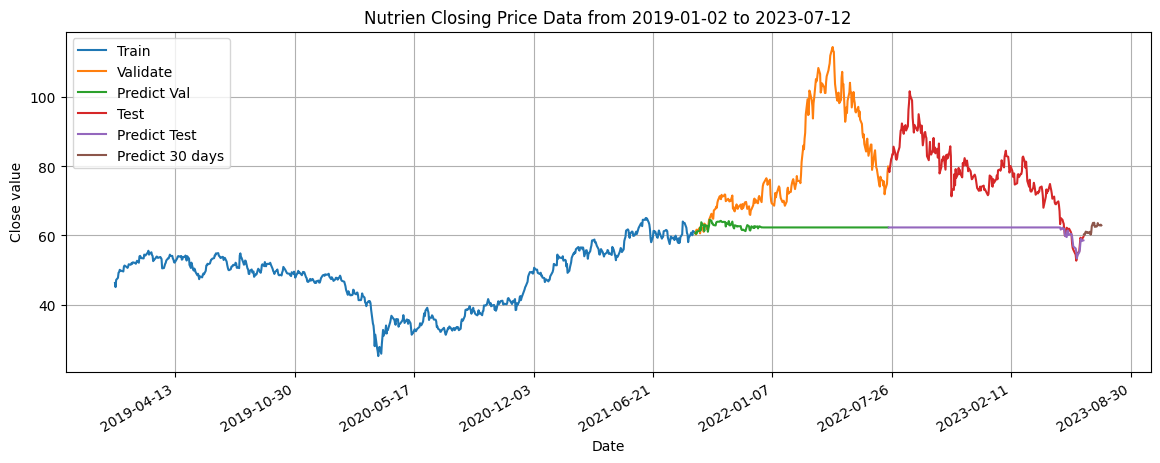

In [73]:
# Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')
plt.plot(val_data_index, y_pred_val_inv, label='Predict Val')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')

plt.plot(predict_data_index, lst_output, label='Predict 30 days')
# Set the date on the x-axis
plt.grid()
plt.title(f"Nutrien Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() #  Rotate date labels for better readability
plt.legend()
plt.savefig('../Image/GBT_622_NTR.png')
plt.show()